## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [1]:
import os
import keras


os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95
Best = [True, False]

In [7]:
# 載入 Callbacks
"""Code Here
設定 callbacks: model checkpoint
"""
from keras.callbacks import ModelCheckpoint


results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""

for b in Best:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Save best only = %r" % (b))
    model_ckpt = ModelCheckpoint(filepath="./tmp.h5", 
                                 monitor="val_loss", 
                                 save_best_only=b)

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer='adam')

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[model_ckpt]
             )
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    save_best_only = "save_best_only %r" % b
    results[save_best_only] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Save best only = True
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
________________________________________________

50000/50000 [==============================] - 1s 18us/step - loss: 0.1443 - acc: 0.9554 - val_loss: 2.8199 - val_acc: 0.4762
Epoch 46/50
50000/50000 [==============================] - 1s 19us/step - loss: 0.1167 - acc: 0.9684 - val_loss: 2.8736 - val_acc: 0.4588
Epoch 47/50
50000/50000 [==============================] - 1s 20us/step - loss: 0.1094 - acc: 0.9704 - val_loss: 3.0224 - val_acc: 0.4721
Epoch 48/50
50000/50000 [==============================] - 1s 20us/step - loss: 0.1097 - acc: 0.9684 - val_loss: 2.8914 - val_acc: 0.4750
Epoch 49/50
50000/50000 [==============================] - 1s 19us/step - loss: 0.1214 - acc: 0.9631 - val_loss: 3.1794 - val_acc: 0.4725
Epoch 50/50
50000/50000 [==============================] - 1s 18us/step - loss: 0.1205 - acc: 0.9627 - val_loss: 3.0854 - val_acc: 0.4553
Save best only = False
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         

Epoch 44/50
50000/50000 [==============================] - 1s 19us/step - loss: 0.1347 - acc: 0.9611 - val_loss: 2.9385 - val_acc: 0.4392
Epoch 45/50
50000/50000 [==============================] - 1s 18us/step - loss: 0.1296 - acc: 0.9610 - val_loss: 2.8648 - val_acc: 0.4760
Epoch 46/50
50000/50000 [==============================] - 1s 18us/step - loss: 0.1296 - acc: 0.9611 - val_loss: 3.0572 - val_acc: 0.4671
Epoch 47/50
50000/50000 [==============================] - 1s 19us/step - loss: 0.1159 - acc: 0.9666 - val_loss: 2.9052 - val_acc: 0.4698
Epoch 48/50
50000/50000 [==============================] - 1s 19us/step - loss: 0.1054 - acc: 0.9695 - val_loss: 3.0982 - val_acc: 0.4389
Epoch 49/50
50000/50000 [==============================] - 1s 18us/step - loss: 0.1147 - acc: 0.9648 - val_loss: 3.2299 - val_acc: 0.4607
Epoch 50/50
50000/50000 [==============================] - 1s 18us/step - loss: 0.1139 - acc: 0.9648 - val_loss: 3.0803 - val_acc: 0.4616


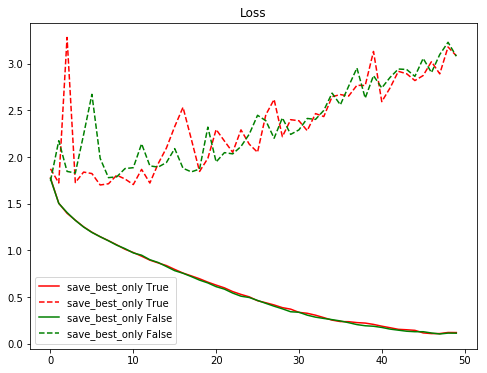

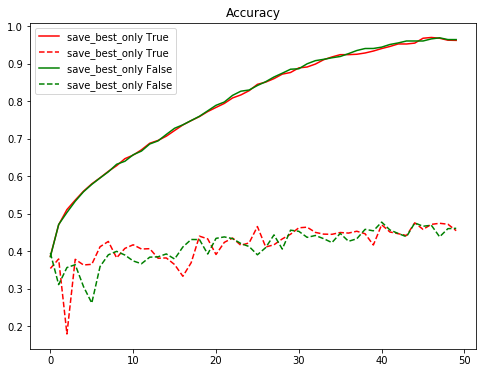

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()